[**Randomized Sampling-Based Fly Local Sensitive Hashing**](https://www.researchgate.net/publication/327994945_Randomized_Sampling-Based_Fly_Local_Sensitive_Hashing) By [Kuan Xu](https://dblp.uni-trier.de/pers/hd/x/Xu:Kuan) and [Yu Qiao](http://automation.sjtu.edu.cn/en/ShowPeople.aspx?info_id=391&info_lb=326&flag=224)

In [1]:
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

import math

import matplotlib.pyplot as plt

from scipy.spatial import distance

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

In [22]:
from scipy.linalg import hadamard

In [2]:
%store -r Datasets
data = Datasets['SIFT-10K']
train = data['train']
test = data['test']
n_train = data['n_train']
n_test = data['n_test']
print(data.keys())

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])


# Main


## Center

In [3]:
train_center = train - train.mean(axis=0)
test_center = test - train.mean(axis=0)

In [4]:
%%time
K = 200
k_near_neighbors = []
for i, q in enumerate(test_center):
    dis = np.array([distance.euclidean(q, p) for p in train_center])
    order_dis = dis.argsort()
    k_near_neighbors.append(order_dis[:K])

CPU times: user 14.5 s, sys: 16.5 ms, total: 14.5 s
Wall time: 14.6 s


## process

In [5]:
S = np.floor(np.random.normal(10, 4, (1, 100))).astype(np.int)[0]

In [6]:
S

array([15,  7, 17, 10,  6, 16, 13, 14,  8, 14, 20, 13, 10,  6,  5,  7, 16,
       16, 10,  3,  7, 15, 14, 14,  5,  9,  7,  2,  1, 10, 14,  8, 13, 15,
       11, 11,  7, 11,  9, 10,  8,  9, 16, 10, 10,  7,  3,  6,  7,  5,  8,
       20, 11, 13, 12,  0, 12,  7, 12, 11,  7,  9, 16,  9,  1,  6, 12, 10,
       10, 10, 10, 14,  6, 13,  6,  7, 13, 14, 17,  1, 17, 12, 10, 11, 14,
        6, 10,  9,  6,  9, 14,  2,  7, 10,  9, 12,  5, 12, 12,  3])

In [27]:
S[S < 0] = 1

In [28]:
S

array([ 4, 14, 12, 11, 11,  7,  9,  4, 11, 14,  9,  7,  8, 16,  7, 10,  4,
        5,  4,  5, 11,  8,  8,  7, 17, 15,  8, 10, 13,  3,  6, 15,  3,  3,
        5, 11,  5, 11,  6, 16,  6,  8, 15, 11,  6, 11,  4, 12, 11, 12,  7,
        6, 10, 11, 13,  8, 17,  8, 13, 14,  5,  7,  5, 15, 10, 11, 10, 11,
       12,  9,  1, 17, 10, 13, 18, 12,  7, 13,  7, 13, 18,  5, 13,  5,  5,
        8, 15, 10, 10,  7,  7,  6, 15, 21, 11,  4, 10, 14, 12, 14])

In [30]:
d = 128

In [33]:
m = 100

In [38]:
np.array([np.random.choice([0, 1], p=[1-_s/d, _s/d], size=d) for _s in S]).shape

(100, 128)

In [24]:
test[0].dot(np.diagflat(np.random.choice([-1, 1], p=[0.5, 0.5], size=128))).dot(hadamard(128))

array([  430,  -428,   -14,   120,   -40,  -466,   368,   422,   896,
       -1098,  -468,   162,  -546,  -372,  -226,   188,  -508,  -502,
        -792,  -178,  -658,   404,   -42,  -356,   602,   688,   382,
        -332,   360,   166,   176,   798,   282,    96,   398,    36,
        -136,   -98,  -368,    54,  -456,    54,   -84,   826,   706,
        -680, -1142,  -560,   580,   578,  -440,   118,  -366,  -240,
         906,   520,   798,   196,  -214,  1088,   152,  -490,   232,
        -330,  -256,   606,   244,   -62,    30,   588,  -282,   164,
         278,   -44,  -286,  -320,    16,   806,   592,   406,   262,
         -60,   306,   144,   244,  -798,  -284,    18,  -216,  -602,
         -60,  -366,   210,  -568,  -654,   808,    76,  -678,  -376,
         486,   166,  -812,  -970,    68,  -642,   356,  1498,   768,
        1004,   394,  -244,  -662,   622,  -124,  -590,   456,  -168,
       -1026,  -544,   182,  -396,   402,  -448,   238,   -30,  -184,
         386, -1096]

In [25]:
def flsh_precision(train, test, s, m, k=4, sigma=None, diagnal=None,
                   near_neighbors=None, K=200,
                   random_state=None, verbose=False):
    """
    Args:
        s: number of select ...  10%
        m: number of Kenyon Cells  20*k, 10*d
        k: Top k (winner take all)
        sigma:
        near_neighbors
        K: k near neighbors
        random_state
        verbose
    """
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)

    n, d = train.shape
    
    if sigma is None:
        M = rand.choice([0, 1], p=[1-s/d, s/d], size=(m, d))
    else:
        S = np.floor(np.random.normal(s, sigma, (1, m))).astype(np.int)[0]
        S[S < 0] = 1
        S[S > d] = d
        
        M = np.array([np.random.choice([0, 1], p=[1-_s/d, _s/d], size=d) for _s in S])

    if diagnal is not None:
        diag_mat = np.diagflat(rand.choice([-1, 1], p=[0.5, 0.5], size=d))
        H = train.dot(diag_mat).dot(hadamard(d)).dot(M.T)
    else:
        H = train.dot(M.T)
    
    H_order = H.argsort(axis=1)
    for i, h in enumerate(H_order[:, :-k]):
        H[i][h] = 0
        H[i][H[i] != 0] = 1

    precision = []
    for i, q in enumerate(test):
        if diagnal is not None:
            h = M.dot(q.dot(diag_mat).dot(hadamard(d)))
        else:
            h = M.dot(q)

        h[h.argsort()[:-k]] = 0
        h[h != 0] = 1

        dis = np.array([distance.hamming(h, h_) for h_ in H])
        
        precision.append(len(np.intersect1d(dis.argsort()[:K], near_neighbors[i])) / K)

    result = np.array(precision).mean()

    if verbose is True:
        if sigma is not None:
            print('s = {}, m = {}, k = {}, sigma = {}, preicison = {}'.format(s, m, k, sigma, result))
        else:
            print('s = {}, m = {}, k = {}, preicison = {}'.format(s, m, k, result))
        
    return result

In [40]:
n, d = train_center.shape
s = 4
k = 32
m = 10 * d

In [27]:
sigma_arr = np.arange(1, 10.5, 0.5)
sigma_arr

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [45]:
%%time
precision_sigma_with_s4_m10d_k32 = []
for sigma in sigma_arr:
    precision_sigma_with_s4_m10d_k32.append(flsh_precision(train_center, test_center, 
                                        s, m, k, sigma, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1, verbose=True))

s = 4, m = 1280, k = 32, sigma = 1.0, preicison = 0.53105
s = 4, m = 1280, k = 32, sigma = 1.5, preicison = 0.5496
s = 4, m = 1280, k = 32, sigma = 2.0, preicison = 0.5479499999999999
s = 4, m = 1280, k = 32, sigma = 2.5, preicison = 0.5435500000000001
s = 4, m = 1280, k = 32, sigma = 3.0, preicison = 0.5347
s = 4, m = 1280, k = 32, sigma = 3.5, preicison = 0.5435000000000001
s = 4, m = 1280, k = 32, sigma = 4.0, preicison = 0.5447500000000001
s = 4, m = 1280, k = 32, sigma = 4.5, preicison = 0.5428999999999999
s = 4, m = 1280, k = 32, sigma = 5.0, preicison = 0.5334
s = 4, m = 1280, k = 32, sigma = 5.5, preicison = 0.5415
s = 4, m = 1280, k = 32, sigma = 6.0, preicison = 0.52785
s = 4, m = 1280, k = 32, sigma = 6.5, preicison = 0.5438999999999999
s = 4, m = 1280, k = 32, sigma = 7.0, preicison = 0.5307499999999999
s = 4, m = 1280, k = 32, sigma = 7.5, preicison = 0.5385
s = 4, m = 1280, k = 32, sigma = 8.0, preicison = 0.5297000000000001
s = 4, m = 1280, k = 32, sigma = 8.5, preicison

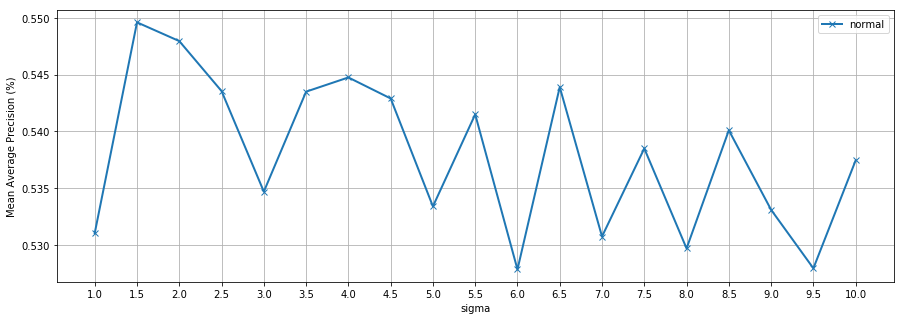

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'x-', linewidth=2, label='normal')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

In [47]:
n, d = train_center.shape
s = 12
k = 32
m = 10 * d

In [48]:
%%time
precision_sigma_with_s12_m10d_k32 = []
for sigma in sigma_arr:
    precision_sigma_with_s12_m10d_k32.append(flsh_precision(train_center, test_center, 
                                        s, m, k, sigma, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1, verbose=True))

s = 12, m = 1280, k = 32, sigma = 1.0, preicison = 0.5515
s = 12, m = 1280, k = 32, sigma = 1.5, preicison = 0.5458
s = 12, m = 1280, k = 32, sigma = 2.0, preicison = 0.548
s = 12, m = 1280, k = 32, sigma = 2.5, preicison = 0.54835
s = 12, m = 1280, k = 32, sigma = 3.0, preicison = 0.5559499999999999
s = 12, m = 1280, k = 32, sigma = 3.5, preicison = 0.5462
s = 12, m = 1280, k = 32, sigma = 4.0, preicison = 0.5449499999999999
s = 12, m = 1280, k = 32, sigma = 4.5, preicison = 0.54315
s = 12, m = 1280, k = 32, sigma = 5.0, preicison = 0.5447499999999998
s = 12, m = 1280, k = 32, sigma = 5.5, preicison = 0.54125
s = 12, m = 1280, k = 32, sigma = 6.0, preicison = 0.5398000000000001
s = 12, m = 1280, k = 32, sigma = 6.5, preicison = 0.53925
s = 12, m = 1280, k = 32, sigma = 7.0, preicison = 0.5517499999999999
s = 12, m = 1280, k = 32, sigma = 7.5, preicison = 0.5373
s = 12, m = 1280, k = 32, sigma = 8.0, preicison = 0.53685
s = 12, m = 1280, k = 32, sigma = 8.5, preicison = 0.53885
s = 12,

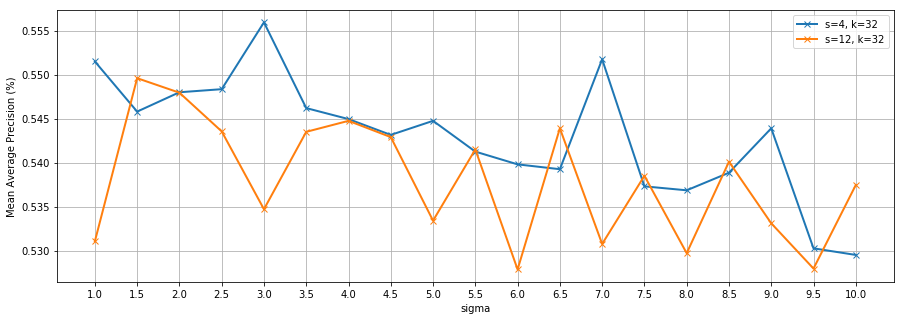

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_sigma_with_s12_m10d_k32, 'x-', linewidth=2, label='s=4, k=32')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'x-', linewidth=2, label='s=12, k=32')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

In [30]:
n, d = train_center.shape
s = 4
k = 64
m = 10 * d

In [31]:
%%time
precision_sigma_with_s4_m10d_k64 = []
for sigma in sigma_arr:
    precision_sigma_with_s4_m10d_k64.append(flsh_precision(train_center, test_center, 
                                        s, m, k, sigma, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1, verbose=True))

s = 4, m = 1280, k = 64, sigma = 1.0, preicison = 0.6264500000000001
s = 4, m = 1280, k = 64, sigma = 1.5, preicison = 0.6322
s = 4, m = 1280, k = 64, sigma = 2.0, preicison = 0.6172500000000001
s = 4, m = 1280, k = 64, sigma = 2.5, preicison = 0.61785
s = 4, m = 1280, k = 64, sigma = 3.0, preicison = 0.6366499999999999
s = 4, m = 1280, k = 64, sigma = 3.5, preicison = 0.6361000000000001
s = 4, m = 1280, k = 64, sigma = 4.0, preicison = 0.63605
s = 4, m = 1280, k = 64, sigma = 4.5, preicison = 0.635
s = 4, m = 1280, k = 64, sigma = 5.0, preicison = 0.6264500000000001
s = 4, m = 1280, k = 64, sigma = 5.5, preicison = 0.61385
s = 4, m = 1280, k = 64, sigma = 6.0, preicison = 0.6264499999999998
s = 4, m = 1280, k = 64, sigma = 6.5, preicison = 0.6206499999999999
s = 4, m = 1280, k = 64, sigma = 7.0, preicison = 0.62585
s = 4, m = 1280, k = 64, sigma = 7.5, preicison = 0.6189000000000001
s = 4, m = 1280, k = 64, sigma = 8.0, preicison = 0.61505
s = 4, m = 1280, k = 64, sigma = 8.5, preicis

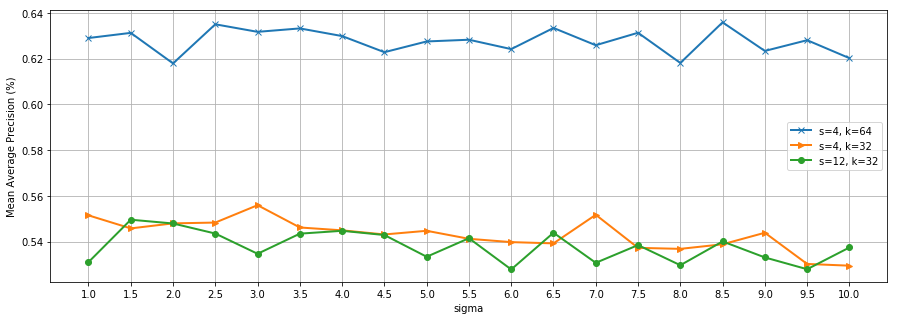

In [52]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64')
plt.plot(sigma_arr, precision_sigma_with_s12_m10d_k32, '>-', linewidth=2, label='s=4, k=32')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'o-', linewidth=2, label='s=12, k=32')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

### original

In [54]:
n, d = train_center.shape
s = 4
k = 64
m = 10 * d

In [55]:
%%time
precision_with_s4_m10d_k64 = []
for sigma in sigma_arr:
    precision_with_s4_m10d_k64.append(flsh_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1, verbose=True))

s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
s = 4, m = 1280, k = 64, preicison = 0.62335
CPU times: user 12min 40s, sys: 36.3 s, total: 13min 16s
Wall time: 7min 5s


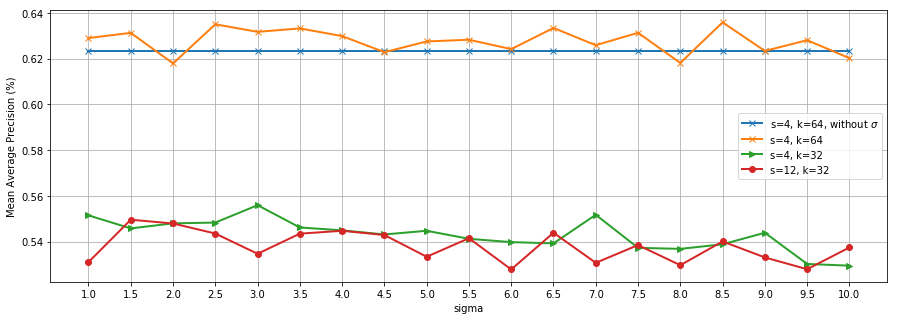

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64, without $\sigma$')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64')
plt.plot(sigma_arr, precision_sigma_with_s12_m10d_k32, '>-', linewidth=2, label='s=4, k=32')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'o-', linewidth=2, label='s=12, k=32')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

### FJLT

In [28]:
n, d = train_center.shape
s = 4
k = 64
m = 10 * d

In [34]:
%%time
precision_fjlt_with_s4_m10d_k64 = []
for sigma in sigma_arr:
    precision_fjlt_with_s4_m10d_k64.append(flsh_precision(train_center, test_center, 
                                        s, m, k, diagnal=True, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1, verbose=True))

s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
s = 4, m = 1280, k = 64, preicison = 0.5932
CPU times: user 12min 8s, sys: 34.9 s, total: 12min 43s
Wall time: 6min 29s


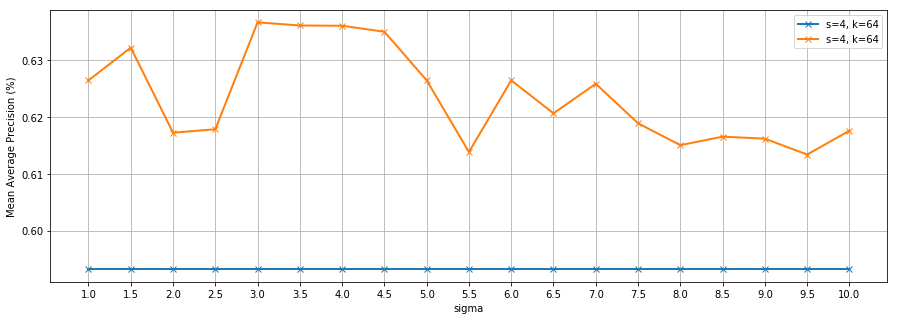

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_fjlt_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

**What?**